
🔍 Evaluating Logistic Regression...

📊 Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.86      0.84       105
           1       0.79      0.74      0.76        74

    accuracy                           0.81       179
   macro avg       0.81      0.80      0.80       179
weighted avg       0.81      0.81      0.81       179


Metrics: {'Accuracy': 0.8100558659217877, 'Precision': 0.7857142857142857, 'Recall': 0.7432432432432432, 'F1-Score': 0.7638888888888888}


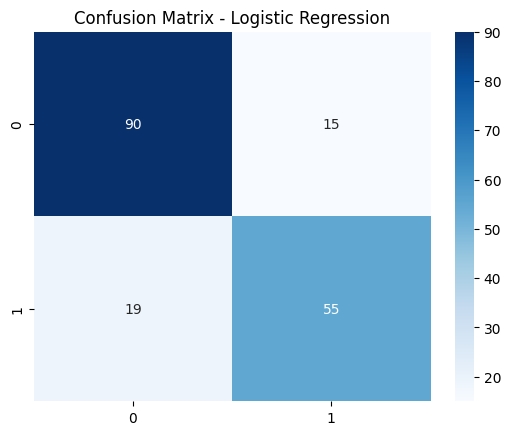


🔍 Evaluating Decision Tree...

📊 Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.88      0.84       105
           1       0.80      0.69      0.74        74

    accuracy                           0.80       179
   macro avg       0.80      0.78      0.79       179
weighted avg       0.80      0.80      0.80       179


Metrics: {'Accuracy': 0.7988826815642458, 'Precision': 0.796875, 'Recall': 0.6891891891891891, 'F1-Score': 0.7391304347826086}


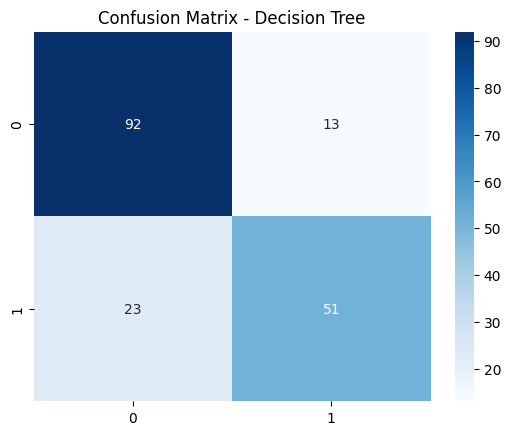

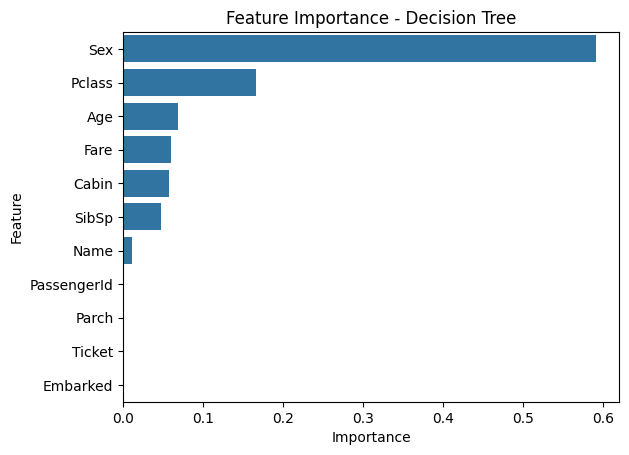


🔍 Evaluating Random Forest...

📊 Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.90      0.87       105
           1       0.84      0.76      0.79        74

    accuracy                           0.84       179
   macro avg       0.84      0.83      0.83       179
weighted avg       0.84      0.84      0.84       179


Metrics: {'Accuracy': 0.8379888268156425, 'Precision': 0.835820895522388, 'Recall': 0.7567567567567568, 'F1-Score': 0.7943262411347518}


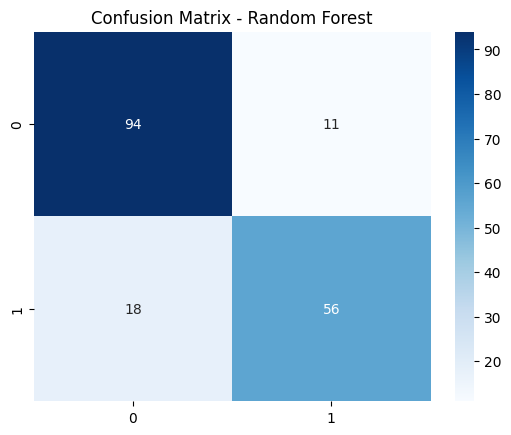

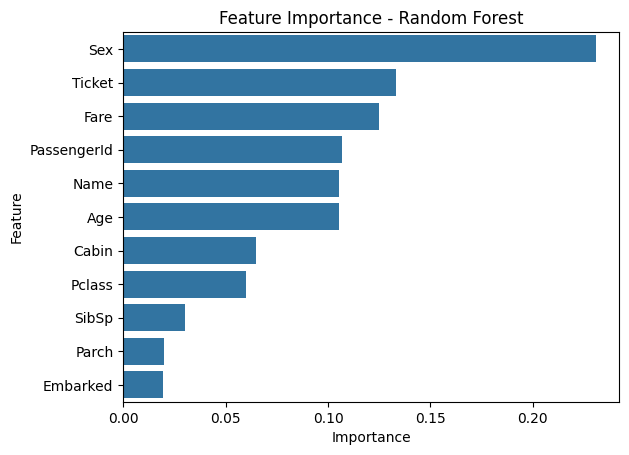

In [20]:
# =====================================
# 🔹 Modular ML Pipeline with Bonuses
# =====================================
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import logging
import joblib

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# ----------------------------
# Setup Logging
# ----------------------------
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
    handlers=[logging.StreamHandler()]
)

# ----------------------------
# Load Dataset Function
# ----------------------------
def load_dataset(path=None, name="titanic"):
    try:
        if name == "titanic":
            df = pd.read_csv("https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv")
            logging.info("Titanic dataset loaded successfully ✅")
        elif path:  # User custom dataset
            df = pd.read_csv(path)
            logging.info(f"Custom dataset '{path}' loaded successfully ✅")
        else:
            raise ValueError("No dataset specified!")
        return df
    except Exception as e:
        logging.error(f"Error loading dataset: {e}")
        raise

# ----------------------------
# Preprocessing
# ----------------------------
def preprocess_data(df, target="Survived"):
    try:
        # Fill missing values
        if "Age" in df.columns:
            df["Age"] = df["Age"].fillna(df["Age"].median())
        if "Embarked" in df.columns:
            df["Embarked"] = df["Embarked"].fillna(df["Embarked"].mode()[0])

        # Encode categorical
        le = LabelEncoder()
        for col in df.select_dtypes(include=["object"]).columns:
            df[col] = le.fit_transform(df[col].astype(str))

        # Features & Target
        X = df.drop(columns=[target])
        y = df[target]

        # Scale
        scaler = StandardScaler()
        X = scaler.fit_transform(X)

        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )
        logging.info("Data preprocessing completed ✅")
        return X_train, X_test, y_train, y_test, df
    except Exception as e:
        logging.error(f"Error in preprocessing: {e}")
        raise

# ----------------------------
# Train Models
# ----------------------------
def train_models(X_train, y_train):
    models = {
        "Logistic Regression": (
            LogisticRegression(max_iter=500),
            {"C": [0.01, 0.1, 1, 10]}
        ),
        "Decision Tree": (
            DecisionTreeClassifier(),
            {"max_depth": [3, 5, 7, None]}
        ),
        "Random Forest": (
            RandomForestClassifier(),
            {"n_estimators": [50, 100], "max_depth": [5, 10, None]}
        )
    }

    trained_models = {}
    for name, (model, params) in models.items():
        try:
            grid = GridSearchCV(model, params, cv=3, scoring="accuracy")
            grid.fit(X_train, y_train)
            best_model = grid.best_estimator_
            trained_models[name] = best_model
            joblib.dump(best_model, f"{name.replace(' ', '_')}_model.pkl")
            logging.info(f"{name} trained ✅ | Best Params: {grid.best_params_}")
        except Exception as e:
            logging.error(f"Error training {name}: {e}")
    return trained_models

# ----------------------------
# Evaluation
# ----------------------------
def evaluate_model(model, X_test, y_test, name):
    try:
        y_pred = model.predict(X_test)
        report = classification_report(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)

        # Metrics
        metrics = {
            "Accuracy": accuracy_score(y_test, y_pred),
            "Precision": precision_score(y_test, y_pred),
            "Recall": recall_score(y_test, y_pred),
            "F1-Score": f1_score(y_test, y_pred)
        }

        print(f"\n🔍 Evaluating {name}...")
        print("\n📊 Classification Report:\n", report)
        print("\nMetrics:", metrics)

        # Confusion Matrix Plot
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
        plt.title(f"Confusion Matrix - {name}")
        plt.show()

        return metrics
    except Exception as e:
        logging.error(f"Error evaluating {name}: {e}")
        return None

# ----------------------------
# Feature Importance (Bonus)
# ----------------------------
def plot_feature_importance(model, df, name):
    try:
        if hasattr(model, "feature_importances_"):
            importance = model.feature_importances_
            features = df.drop(columns=["Survived"]).columns
            fi_df = pd.DataFrame({"Feature": features, "Importance": importance})
            fi_df = fi_df.sort_values("Importance", ascending=False)

            sns.barplot(x="Importance", y="Feature", data=fi_df)
            plt.title(f"Feature Importance - {name}")
            plt.show()
        else:
            logging.warning(f"{name} does not support feature importance ❌")
    except Exception as e:
        logging.error(f"Error plotting feature importance: {e}")

# ----------------------------
# Main Script
# ----------------------------
if __name__ == "__main__":
    logging.info("🚀 Starting ML Pipeline...")

    # Step 1: Load dataset (Titanic by default)
    df = load_dataset()

    # Step 2: Preprocess
    X_train, X_test, y_train, y_test, processed_df = preprocess_data(df)

    # Step 3: Train
    trained_models = train_models(X_train, y_train)

    # Step 4: Evaluate & Feature Importance
    all_metrics = {}
    for name, model in trained_models.items():
        metrics = evaluate_model(model, X_test, y_test, name)
        all_metrics[name] = metrics
        plot_feature_importance(model, processed_df, name)

    logging.info("✅ ML Pipeline Completed Successfully!")
